In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Lung_Cancer_dataset.csv")

df.head()

Saving Lung_Cancer_dataset.csv to Lung_Cancer_dataset.csv


,Name,Surname,Age,Smokes,AreaQ,Alkhol,Result
0,John,Wick,35,3,5,4,1
1,John,Constantine,27,20,2,5,1
2,Camela,Anderson,30,0,5,2,0
3,Alex,Telles,28,0,8,1,0
4,Diego,Maradona,68,4,5,6,1


In [3]:
df = df.drop(columns=["Name", "Surname"], errors="ignore")

# Features and target
X = df.drop("Result", axis=1)
y = df["Result"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (47, 4)
Test shape: (12, 4)


In [4]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

def metrics_report(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Confusion Matrix": confusion_matrix(y_true, y_pred)
    }

baseline_results = metrics_report(y_test, y_pred)
baseline_results

{'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1': 1.0,
 'Confusion Matrix': array([[6, 0],
        [0, 6]])}

In [5]:
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False)

,0
Alkhol,0.792048
AreaQ,0.143861
Age,0.064091
Smokes,0.000000


In [6]:
pipe_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)), # keep ≥95% variance
    ("dt", DecisionTreeClassifier(random_state=42))
])

pipe_pca.fit(X_train, y_train)
y_pred_pca = pipe_pca.predict(X_test)

pca = pipe_pca.named_steps["pca"]
print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio (sum):", pca.explained_variance_ratio_.sum())

pca_results = metrics_report(y_test, y_pred_pca)
pca_results

Number of PCA components: 4
Explained variance ratio (sum): 1.0


{'Accuracy': 0.9166666666666666,
 'Precision': 0.8571428571428571,
 'Recall': 1.0,
 'F1': 0.9230769230769231,
 'Confusion Matrix': array([[5, 1],
        [0, 6]])}

In [7]:
print("Baseline Decision Tree:", baseline_results)
print("\nPCA + Decision Tree:", pca_results)

Baseline Decision Tree: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0, 'Confusion Matrix': array([[6, 0],
       [0, 6]])}

PCA + Decision Tree: {'Accuracy': 0.9166666666666666, 'Precision': 0.8571428571428571, 'Recall': 1.0, 'F1': 0.9230769230769231, 'Confusion Matrix': array([[5, 1],
       [0, 6]])}


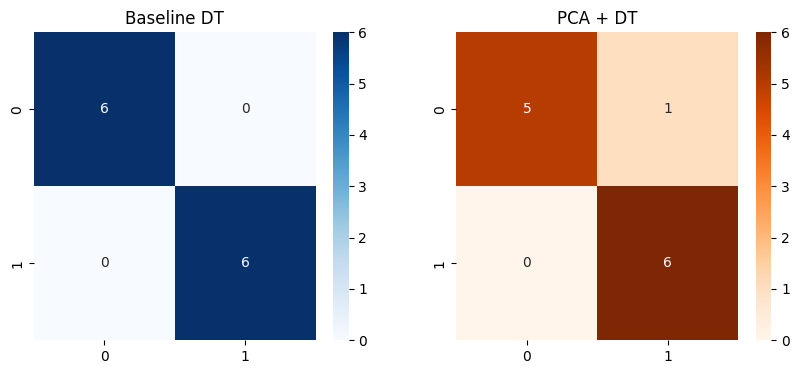

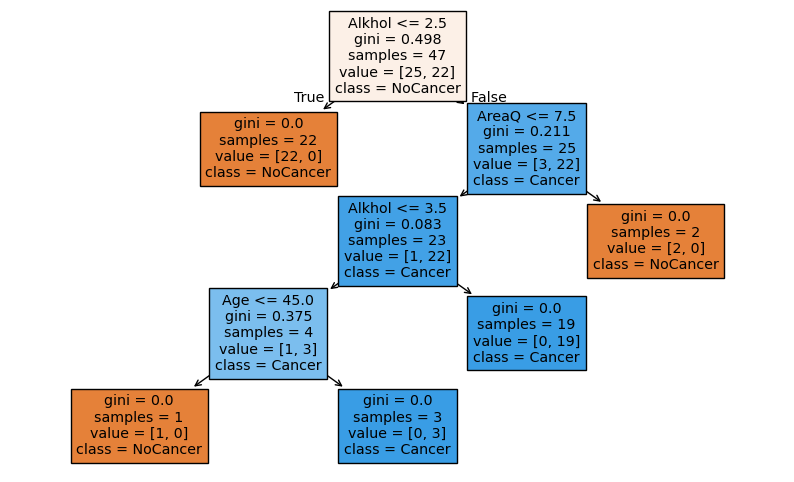

In [8]:
# Confusion Matrix plot
import seaborn as sns

cm1 = baseline_results["Confusion Matrix"]
cm2 = pca_results["Confusion Matrix"]

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Baseline DT")
sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("PCA + DT")
plt.show()

# Decision Tree visualization (Baseline)
plt.figure(figsize=(10,6))
plot_tree(dt, feature_names=X.columns, class_names=["NoCancer", "Cancer"], filled=True)
plt.show()
